<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/Linnaeus_resnet56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import numpy as np
import os
import math
import tensorflow as tf

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 100
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 5

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/Linnaeus_pickle'
image_size = (128, 128)
input_shape = (128, 128, 3)
num_classes = 100

In [3]:
import gzip
import pickle

os.chdir(path)

with gzip.open('Linnaeus5_x_trainData.pickle', 'rb') as f:
    x_train = pickle.load(f)
    
with gzip.open('Linnaeus5_x_testData.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with gzip.open('Linnaeus5_y_trainData.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with gzip.open('Linnaeus5_y_testData.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [4]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [5]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet32v1
x_train shape: (6000, 128, 128, 3)
6000 train samples
2000 test samples
y_train shape: (6000, 5)


In [6]:
model_path = '/content/gdrive/My Drive/Linnaeus5/Linnaeus5_ResNet32v1_model.105.h5'
model = tf.keras.models.load_model(model_path) # load model

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

63/63 [==============================] - 9s 124ms/step - loss: 0.6186 - acc: 0.8885


[0.61861252784729, 0.8884999752044678]

In [9]:
print(y_pred)

[[1.0000000e+00 5.8101871e-23 1.9564451e-19 1.8530326e-18 3.0512041e-14]
 [9.9988675e-01 1.2444112e-13 9.5971533e-05 3.4133770e-08 1.7279679e-05]
 [1.0000000e+00 1.2730941e-17 3.6721691e-20 2.4266975e-16 7.2500852e-17]
 ...
 [1.0518075e-08 3.9176193e-06 2.0602144e-07 1.5577194e-06 9.9999428e-01]
 [1.5675576e-05 2.1431823e-08 8.9410435e-07 2.0460175e-05 9.9996293e-01]
 [2.2732009e-05 6.2135612e-03 7.2014569e-05 3.9397744e-03 9.8975194e-01]]


In [10]:
print(sum(y_pred[50]))

0.9999999942281228


In [11]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[1.19209304e-07 1.13255235e-04 1.19209304e-07 ... 5.66245717e-06
 3.70747766e-05 1.03009380e-02]


In [12]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [13]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

1777
223


In [14]:
import matplotlib.pyplot as plt

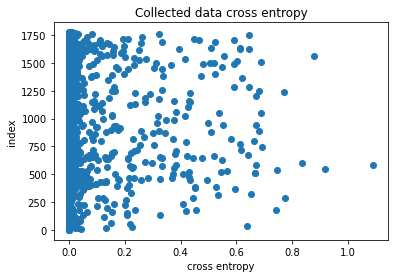

In [15]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

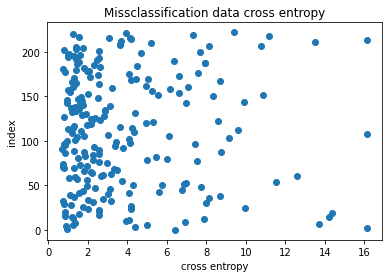

In [16]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

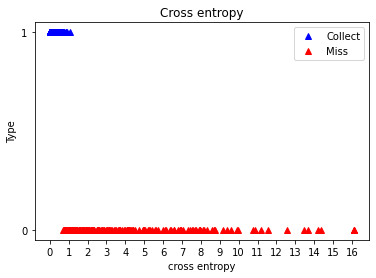

In [17]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [18]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.0896044
0.71812403


In [19]:
cnt = 0

for i in collect_Cce : 
  if i < 0.0001 :
    cnt = cnt + 1
print(cnt)
print(cnt/len(collect_Cce))

792
0.445694991558807


In [20]:
def static_Threshold() :
  threshold = [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
  return threshold

In [21]:
staticThreshold = static_Threshold()
print(staticThreshold)

[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


In [22]:
n_cce = cce/max(cce)

In [23]:
def dynamic_Threshold(cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [2.326, 1.96, 1.645] # 95%, 97.5%, 99% one-tails
  threshold = []
  x_ = np.mean(cce)
  o = np.std(cce)
  n = len(cce) **(1/2)
  print(x_)
  print(o)
  print(n)
  for z in Z :
    threshold.append(x_- (z * o)/n)

  return threshold

In [24]:
dynamicThreshold = dynamic_Threshold(n_cce)
dynamicThreshold.append(min(missclassification_Cce))
print(dynamicThreshold)

0.028986061
0.100261755
44.721359549995796
[0.023771352737355506, 0.024591895824697365, 0.025298100940852244, 0.71812403]


In [25]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [26]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [27]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [28]:
for i in range(len(PMD_By_Static_Threshold)) :
  print(staticThreshold[i], len(PMD_By_Static_Threshold[i]))

for i in range(len(PMD_By_Dynamic_Threshold)) :
  print(dynamicThreshold[i], len(PMD_By_Dynamic_Threshold[i]))

1e-07 1777
1e-06 1351
1e-05 1189
5e-05 1048
0.0001 985
0.0005 810
0.001 743
0.01 478
0.05 288
0.1 220
0.2 154
0.3 110
0.4 78
0.5 52
0.023771352737355506 369
0.024591895824697365 368
0.025298100940852244 367
0.71812403 8


In [29]:
import cv2

In [30]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((64, 64), angle, 1)
    new_img = cv2.warpAffine(img, m, (128, 128), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [31]:
def img_trim(img, size) :
  w = 128
  h = 128
  new_img = img[size:size+h, size:size+w]
  return new_img

In [32]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(128*rate/2 - 64)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(64 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (128, 128), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [33]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [34]:
def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

In [35]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  print("        PMD : " + str(len(PMD)))
  print("        MD : " + str(len(MD)))
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [36]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [37]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

In [38]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [39]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [40]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [41]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [42]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.8825
    Find MD : 73
      static threshold
        1st static threshold
        PMD : 1777
        MD : 73
        Precision : 0.04108047270680923
        Recall : 1.0

        2st static threshold
        PMD : 1351
        MD : 73
        Precision : 0.0540340488527017
        Recall : 1.0

        3st static threshold
        PMD : 1189
        MD : 73
        Precision : 0.061396131202691336
        Recall : 1.0

        4st static threshold
        PMD : 1048
        MD : 73
        Precision : 0.06965648854961833
        Recall : 1.0

        5st static threshold
        PMD : 985
        MD : 73
        Precision : 0.07411167512690356
        Recall : 1.0

        6st static threshold
        PMD : 810
        MD : 73
        Precision : 0.09012345679012346
        Recall : 1.0

        7st static threshold
        PMD : 743
        MD : 73
        Precision : 0.09825033647375504
        Recall : 1.0

        8st static threshold
        PMD : 478
   

In [43]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.8875
    Find MD : 59
      static threshold
        1st static threshold
        PMD : 1777
        MD : 59
        Precision : 0.033202025886325266
        Recall : 1.0

        2st static threshold
        PMD : 1351
        MD : 59
        Precision : 0.043671354552183565
        Recall : 1.0

        3st static threshold
        PMD : 1189
        MD : 59
        Precision : 0.0496215306980656
        Recall : 1.0

        4st static threshold
        PMD : 1048
        MD : 59
        Precision : 0.05629770992366412
        Recall : 1.0

        5st static threshold
        PMD : 985
        MD : 59
        Precision : 0.05989847715736041
        Recall : 1.0

        6st static threshold
        PMD : 810
        MD : 59
        Precision : 0.0728395061728395
        Recall : 1.0

        7st static threshold
        PMD : 743
        MD : 59
        Precision : 0.07940780619111709
        Recall : 1.0

        8st static threshold
        PMD : 478
 

In [44]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.8685
    Find MD : 114
      static threshold
        1st static threshold
        PMD : 1777
        MD : 114
        Precision : 0.06415306696679797
        Recall : 1.0

        2st static threshold
        PMD : 1351
        MD : 114
        Precision : 0.0843819393042191
        Recall : 1.0

        3st static threshold
        PMD : 1189
        MD : 114
        Precision : 0.095878889823381
        Recall : 1.0

        4st static threshold
        PMD : 1048
        MD : 114
        Precision : 0.10877862595419847
        Recall : 1.0

        5st static threshold
        PMD : 985
        MD : 114
        Precision : 0.11573604060913706
        Recall : 1.0

        6st static threshold
        PMD : 810
        MD : 114
        Precision : 0.14074074074074075
        Recall : 1.0

        7st static threshold
        PMD : 743
        MD : 114
        Precision : 0.15208613728129206
        Recall : 0.9912280701754386

        8st static threshold
  

In [45]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.14475082848746326, 0.17920881651451598, 0.1946547051677413, 0.210559796437659, 0.21680767061477718, 0.24540466392318244, 0.2552714221624047, 0.29451417945141795, 0.3499228395061728, 0.3762626262626262, 0.3888888888888889, 0.3909090909090909, 0.43162393162393164, 0.4999999999999999]
[1.0, 0.9522306537050811, 0.9179096514095659, 0.8830381171361928, 0.8598825576509173, 0.8114221668314137, 0.7804112065947345, 0.5988474457784572, 0.4440710436909645, 0.37058952069476253, 0.2740724964486395, 0.19899521391185426, 0.15587277308562875, 0.11965570606664683]
[0.023771352737355506, 0.024591895824697365, 0.025298100940852244, 0.71812403]
[0.3360433604336044, 0.33605072463768115, 0.3369663941871026, 0.4027777777777778]
[0.534585256385107, 0.5336004143981788, 0.5336004143981788, 0.013564221122842108]


In [46]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.05936972425436129, 0.07809030347890451, 0.0887300252312868, 0.10019083969465649, 0.1065989847715736, 0.1271604938271605, 0.13593539703903096, 0.18357740585774057, 0.24305555555555555, 0.2693181818181818, 0.2987012987012987, 0.31818181818181823, 0.3589743589743589, 0.3798076923076923]
[1.0, 1.0, 1.0, 0.9967948717948718, 0.9967948717948718, 0.9828691423519009, 0.9689434129089302, 0.8650708462587481, 0.7046232308505832, 0.6033164794488581, 0.4694158729445112, 0.354477625919765, 0.28663324791320116, 0.20554607334998917]
[0.023771352737355506, 0.024591895824697365, 0.025298100940852244, 0.71812403]
[0.21883468834688347, 0.21942934782608697, 0.22002724795640327, 0.46875]
[0.8012131424974791, 0.8012131424974791, 0.8012131424974791, 0.03987651010590812]


In [47]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.0976364659538548, 0.12638786084381937, 0.14192598822539948, 0.1586354961832061, 0.166751269035533, 0.19722222222222224, 0.2123149394347241, 0.26935146443514646, 0.3298611111111111, 0.36704545454545456, 0.413961038961039, 0.4113636363636364, 0.46474358974358976, 0.5240384615384616]
[1.0, 0.9904513888888888, 0.9835069444444444, 0.9731202107279694, 0.965607040229885, 0.9471384099616857, 0.9370497240507757, 0.7843737343248537, 0.5906582813819079, 0.5090129955465323, 0.40077926604085706, 0.28047043489666107, 0.22671635696610512, 0.17064857680437212]
[0.023771352737355506, 0.024591895824697365, 0.025298100940852244, 0.71812403]
[0.30081300813008127, 0.30163043478260865, 0.3024523160762943, 0.53125]
[0.6862196387496111, 0.6862196387496111, 0.6862196387496111, 0.02532712095112123]
